# Normalization

This jupyter notebook demonstrates how to perform normalization with `mnts`. The most important part is to normalize the input images' intensity profile to a standard mapping. In this study, we use Nyul normalization, which is a piecewise linear method that requires a training step. 

First, we need to load some packages:

In [1]:
import mnts
from pathlib import Path
from typing import *


/home/lwong/Toolkits/Anaconda/envs/texture-vision/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# * Read from folder
root_dir = Path("../NPC_Segmentation/72.RecurrentData/")
pre_dir = root_dir / "StudyFilesBySequence/Pre"
post_dir = root_dir / "StudyFilesBySequence/Post"

pre_seq = set([p.name for p in pre_dir.iterdir()])
post_seq = set([p.name for p in post_dir.iterdir()])

all_seq = pre_seq | post_seq
all_seq.remove('MISC') # MISC holds segmentation ground-truth for post-treatment scans
print(all_seq)


{'T1W_TRA', 'T2W-FS_TRA', 'CE-NECK_TRA', 'CE-T1W_TRA', 'CE-T1W-FS_TRA', 'CE-eTHRIVE_TRA', 'T2W_TRA'}


In [3]:

def get_all_nii_files(seq:str) -> List :
    """Get nii files in both pre- and post- directories"""
    pre_seq_dir = pre_dir / seq
    post_seq_dir = post_dir / seq
    
    all_nii_files = list(pre_seq_dir.glob("*nii.gz")) + list(post_seq_dir.glob("*nii.gz"))
    return all_nii_files

# * creates a dict mapping all files of the same sequence
all_files = {
    k: get_all_nii_files(k) for k in all_seq
}

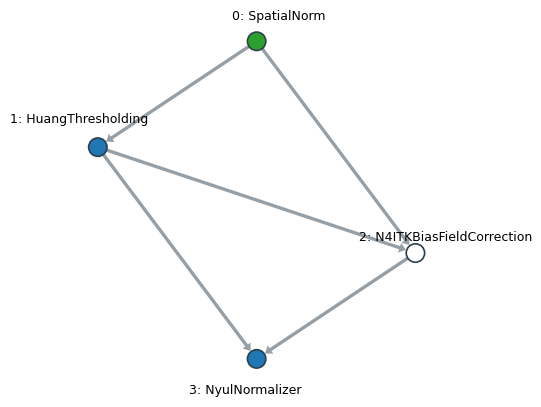

In [4]:
# Creates the normalization graph
from mnts.mnts_logger import MNTSLogger
from mnts.filters import MNTSFilterGraph, mpi_wrapper
from mnts.utils import repeat_zip

notebook_logger = MNTSLogger(".", keep_file=False, log_level='warning')
MNTSLogger.set_global_log_level("warning")

graph: MNTSFilterGraph = MNTSFilterGraph.CreateGraphFromYAML(root_dir / "configs/normalization_graph.yml")
graph.plot_graph()

In [7]:
import tempfile

temp_output_path = root_dir / "_temp"
temp_output_path.mkdir(exist_ok=True)
config_path = root_dir / "configs/normalization_graph.yml"

# * For each sequence, train a graph
for sequence in all_files:
    z = ([3], [f.name for f in all_files[sequence]], [temp_output_path / sequence], all_files[sequence])
    # result = mpi_wrapper(graph.prepare_training_files, z)
    graph = MNTSFilterGraph.CreateGraphFromYAML(config_path)
    graph.train_node(3, temp_output_path / sequence, temp_output_path / sequence / "trained_states")

KeyboardInterrupt: 

In [11]:
import SimpleITK as sitk

# * Now that everything is ready, perform normalization for all images
def normalize_images(images: List[Path], output_dir: Path, state_dir: Path):
    G = MNTSFilterGraph.CreateGraphFromYAML(config_path)
    G.load_node_states(3, state_dir)

    """
    Multi-thread
    """
    # images = [f for f in folder.iterdir() if f.name.find('nii') != -1]
    output_prefix = [im.name for im in images]
    # Prepare
    z = [output_prefix, [output_dir], images]
    mpi_wrapper(G.mpi_execute, z, num_worker=10)


for sequence in all_files:
    seq_dir = temp_output_path / sequence
    seq_trained_state = temp_output_path / sequence / "trained_states"    
    seq_output_path = temp_output_path / sequence / "normalized"
    if not seq_output_path.is_dir():
        seq_output_path.mkdir(parents=True, exist_ok=True)
    normalize_images(all_files[sequence], seq_output_path, seq_trained_state)

# Checking

Lets check the files of normalized images we created.

In [33]:
import shutil
import re

normalized_images = {}
for sequence in all_files:
    seq_output_path = temp_output_path / sequence / "normalized" / "NyulNormalizer"
    normalized_images[sequence] = list(seq_output_path.iterdir())

# Output
normalized_images_out_path = root_dir / "NormalizedFilesBySequence"
    
# Sort them into their place
pre_post_regex = r"(?i)(pre|post)"
for sequence, files in normalized_images.items():
    for file in files:
        mo = re.search(pre_post_regex, str(file.name))
        p = mo.group()
        out = normalized_images_out_path / p / sequence
        if not out.is_dir():
            out.mkdir(parents=True, exist_ok=True)
        #! Uncomment this for this to work
        shutil.copy2(file, out)
